In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)

Mounted at /content/drive


In [ ]:
# extract data from zip file
import zipfile
import os

# Define the path to your zip file and the directory where you want to extract it
zip_file_path = '/content/drive/MyDrive/465 Project/new_archive.zip'
extract_folder_path = '/content/data'

os.makedirs(extract_folder_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)

### Imports

In [ ]:
# lib imports
import torch
import os
import numpy as np
import pandas as pd
import random
import cv2

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3
IMG_COUNT = 480

In [ ]:
# set this between [1, 10] for differently composed datasets
# reference: https://arxiv.org/pdf/2307.05911.pdf
TRAINING_SET = 1

### Model : Sa2Net from Github

In [ ]:
!wget https://raw.githubusercontent.com/mustansarfiaz/SA2-Net/main/SegPC2021_ISIC2018/models/mynet/sasanet.py

--2024-04-29 12:54:56--  https://raw.githubusercontent.com/mustansarfiaz/SA2-Net/main/SegPC2021_ISIC2018/models/mynet/sasanet.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15648 (15K) [text/plain]
Saving to: ‘sasanet.py’

sasanet.py          100%[===================>]  15.28K  --.-KB/s    in 0.001s  

2024-04-29 12:54:56 (25.7 MB/s) - ‘sasanet.py’ saved [15648/15648]



In [ ]:
from sasanet import MyNet

device = "cuda" if torch.cuda.is_available() else "cpu"
model = MyNet(n_channels=3, base_channel=64, n_classes=1, img_size=224).to(device)


In [ ]:
# # Calculate total parameters
# total_params = sum(p.numel() for p in model.parameters())
# trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# non_trainable_params = total_params - trainable_params

# # Output the parameter counts
# print(f"Total parameters: {total_params}")
# print(f"Trainable parameters: {trainable_params}")
# print(f"Non-trainable parameters: {non_trainable_params}")

Total parameters: 32484308
Trainable parameters: 32484308
Non-trainable parameters: 0


# Dataset splitting

# TestSets

In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class GrainDataHandler:
    def __init__(self, image_dir, mask_dir, img_width, img_height, training_set=1):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.target_size = (img_width, img_height)
        self.training_set = training_set
        self.images = []
        self.masks = []

    def load_data(self):
        if self.training_set == 1:
            print("Selected Training Set 1: Manually Segmented - 100% (480)")
            self.images = [self.process_file(os.path.join(self.image_dir, file)) for file in sorted(os.listdir(self.image_dir))]
            self.masks = [self.process_file(os.path.join(self.mask_dir, file), mask=True) for file in sorted(os.listdir(self.mask_dir))]
            print(f"Loaded images and masks count: {len(self.images)}")

    def process_file(self, file_path, mask=False):
        img = cv2.imread(file_path)
        img = cv2.resize(img, self.target_size)
        if mask:
            img = np.where(img > 245, True, False)
            img = np.any(img, axis=2).astype(float)
            return img.reshape(1, *self.target_size)
        return np.transpose(img, (2, 0, 1))

    def split_dataset(self, split_ratio=(0.8, 0.1, 0.1)):
        dataset = GrainDataset(np.array(self.images), np.array(self.masks))
        total_count = len(dataset)
        train_count = int(split_ratio[0] * total_count)
        val_count = int(split_ratio[1] * total_count)
        test_count = total_count - train_count - val_count
        return random_split(dataset, [train_count, val_count, test_count])

class GrainDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx]).float()
        mask = torch.from_numpy(self.masks[idx]).float()
        return image, mask

# Usage
image_dir = '/content/data/GRAIN DATA SET/RG'
mask_dir = '/content/data/GRAIN DATA SET/RGMask'
img_width, img_height = 224, 224  # Set your dimensions

data_handler = GrainDataHandler(image_dir, mask_dir, img_width, img_height)
data_handler.load_data()
train_dataset, val_dataset, test_dataset = data_handler.split_dataset()

# Now you can use these datasets with DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)



Selected Training Set 1: Manually Segmented - 100% (480)
Loaded images and masks count: 480


# Train

In [ ]:
# Define callbacks
class ModelCheckpoint:
    def __init__(self, checkpoint_path):
        self.checkpoint_path = checkpoint_path
        self.best_loss = float('inf')

    def __call__(self, model, epoch, train_loss, val_loss):
        if val_loss < self.best_loss:
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_loss' : train_loss,
            'val_loss': val_loss,
            }, self.checkpoint_path)
            print("Checkpoint saved")
            self.best_loss = val_loss

from datetime import datetime
checkpoint_path = f'/content/drive/MyDrive/465 Project/Ex1-SS316L-Grains-500X/Sa2net_diceloss_{datetime.now().strftime("%d%m%Y %H:%M:%S")}.pt'

# os.makedirs("/content/drive/MyDrive/465 Project", exist_ok=True) # already exists
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpointer = ModelCheckpoint(checkpoint_path)

In [ ]:
import torch
from torch.nn import functional as F

EPSILON = 1e-6

class DiceLoss(torch.nn.Module):
    def __init__(self,):
        super().__init__()

    def forward(self, pred, mask):
        pred = pred.flatten()
        mask = mask.flatten()

        intersect = (mask * pred).sum()
        dice_score = 2*intersect / (pred.sum() + mask.sum() + EPSILON)
        dice_loss = 1 - dice_score
        return dice_loss


In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss)
            self.counter = 0

    def save_checkpoint(self, val_loss):
        """Saves model when validation loss decrease."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model...')
        self.val_loss_min = val_loss

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = DiceLoss()

early_stopper = EarlyStopping(patience=10, verbose=True)

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)

num_epochs = 40
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    num_samples = 0

    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()  # Clear the gradients
        preds4, preds3, preds2, preds1 = model(inputs)
        # Calculate loss from multiple outputs
        loss4 = criterion(preds4, targets)
        loss3 = criterion(preds3, targets)
        loss2 = criterion(preds2, targets)
        loss1 = criterion(preds1, targets)
        loss = loss4 + loss3 + loss2 + loss1

        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters
        train_loss += loss.item() * inputs.size(0)
        num_samples += inputs.size(0)

    train_loss /= num_samples

    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    num_val_samples = 0
    with torch.no_grad():  # Validation loop
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            preds = model(inputs)
            val_loss += criterion(preds, targets).item() * inputs.size(0)
            num_val_samples += inputs.size(0)

        val_loss /= num_val_samples

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Scheduler step is called after updating the validation loss
    scheduler.step(val_loss)

    # Checkpointing and early stopping
    checkpointer(model, epoch, train_loss, val_loss)
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("Early stopping")
        break


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/40], Train Loss: 0.9159, Val Loss: 0.2293
Checkpoint saved
Validation loss decreased (inf --> 0.229293).  Saving model...
Epoch [2/40], Train Loss: 0.7070, Val Loss: 0.2042
Checkpoint saved
Validation loss decreased (0.229293 --> 0.204152).  Saving model...
Epoch [3/40], Train Loss: 0.6337, Val Loss: 0.1870
Checkpoint saved
Validation loss decreased (0.204152 --> 0.186952).  Saving model...
Epoch [4/40], Train Loss: 0.5821, Val Loss: 0.1710
Checkpoint saved
Validation loss decreased (0.186952 --> 0.170969).  Saving model...
Epoch [5/40], Train Loss: 0.5432, Val Loss: 0.1571
Checkpoint saved
Validation loss decreased (0.170969 --> 0.157124).  Saving model...
Epoch [6/40], Train Loss: 0.5085, Val Loss: 0.1487
Checkpoint saved
Validation loss decreased (0.157124 --> 0.148691).  Saving model...
Epoch [7/40], Train Loss: 0.4807, Val Loss: 0.1414
Checkpoint saved
Validation loss decreased (0.148691 --> 0.141356).  Saving model...
Epoch [8/40], Train Loss: 0.4570, Val Loss: 0.1331
Ch

In [ ]:
current_checkpoint = torch.load(checkpoint_path)
model.load_state_dict(current_checkpoint['model_state_dict'])
model.eval()
print(current_checkpoint['train_loss'],current_checkpoint['val_loss'])

0.13112890409926573 0.09748125076293945


Checkpointer Path

In [ ]:
checkpoint_path

'/content/drive/MyDrive/465 Project/Ex1-SS316L-Grains-500X/Sa2net_diceloss_29042024 12:55:01.pt'

# Scores

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 10.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

# Results

In [ ]:
from torchmetrics.functional import dice
from torchmetrics.functional import jaccard_index

total_jaccard_score = 0.0
total_dice_score = 0.0
total_num_samples = 0

for images, masks in test_loader:
    batch_size = images.size(0)  # Get the actual batch size
    total_num_samples += batch_size

    with torch.no_grad():
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        preds = model(images)

        for ind in range(len(preds)):
            pred_tensor = (preds[ind] > 0.5).float()
            gt_tensor = masks[ind].to(torch.int64)  # Convert mask tensor to integer tensor

            dice_score = dice(pred_tensor, gt_tensor)
            total_dice_score += dice_score.item()

            jaccard_score = jaccard_index(pred_tensor, gt_tensor, task='binary')
            total_jaccard_score += jaccard_score.item()

average_dice_score = total_dice_score / total_num_samples
average_jaccard_score = total_jaccard_score / total_num_samples


print(f"epoch-> {num_epochs}")
print(f"Total Number samples: {total_num_samples}")
print(f"Average Dice Score: {average_dice_score}")
print(f"Average Jaccard Index: {average_jaccard_score}")

epoch-> 40
Total Number samples: 48
Average Dice Score: 0.9017558979491392
Average Jaccard Index: 0.8214371887346109


#####Checking Other Threshold values:

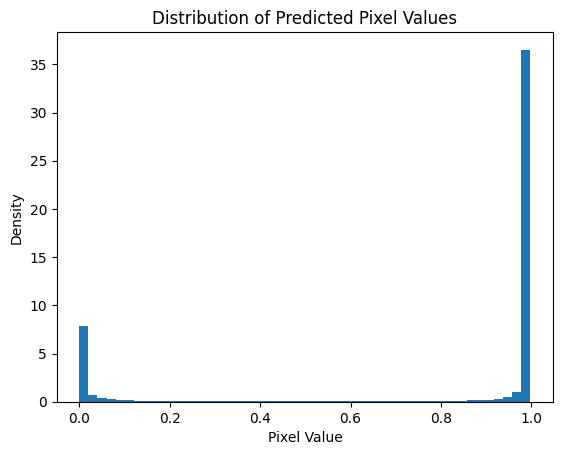

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt


model.eval()

all_preds = []

with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        preds = model(images)
        all_preds.extend(preds.flatten().cpu().numpy())  # Flatten and move to CPU

all_preds_np = np.array(all_preds)

# Plot the histogram
plt.hist(all_preds_np, bins=50, density=True)
plt.title('Distribution of Predicted Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.show()


## Display Result

In [ ]:
def display_results(image, ground_truth_mask, predicted_mask):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display input image
    axes[0].imshow(np.transpose(image, (1, 2, 0)))
    axes[0].set_title('Input Image')

    # Display ground truth mask
    axes[1].imshow(np.squeeze(ground_truth_mask))
    axes[1].set_title('Ground Truth Mask')

    # Display predicted mask
    axes[2].imshow(np.squeeze(predicted_mask))
    axes[2].set_title('Predicted Mask')

    plt.show()